<a href="https://colab.research.google.com/github/paulorfbr/transformers_course/blob/fine_tuning_seq2seq_machine_translation/Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets sentencepiece

In [2]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 6.3 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset
# possible language pairs: https://opus.nlpl.eu/KDE4.php
data = load_dataset("kde4", lang1="en", lang2="pt")
data

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for kde4 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/kde4
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 229418
    })
})

In [4]:
small = data["train"].shuffle(seed=42).select(range(1_000))

In [5]:
split = small.train_test_split(seed=42)

In [6]:
split["train"][0]

{'id': '187371',
 'translation': {'en': 'Show text labels',
  'pt': 'Mostrar & etiquetas de texto'}}

In [7]:
from transformers import AutoTokenizer

checkpoint = "Helsinki-NLP/opus-mt-tc-big-en-pt"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [8]:
en = split['train'][5]['translation']['en']
pt = split['train'][5]['translation']['pt']
en, pt

('You can use the nntp kioslave by typing nntp: / /yourserver/ groupname into the & konqueror; URL bar.',
 "Poderá usar o 'kioslave' 'nntp' se escrever nntp: // oseuservidor/ nomedogrupo na barra do URL do & konqueror;.")

In [9]:
inputs = tokenizer(en)
inputs

{'input_ids': [54607, 8796, 52255, 49848, 34103, 35171, 36744, 29170, 28277, 29514, 52650, 8449, 51589, 34103, 35171, 36744, 13, 106, 106, 54616, 45926, 27, 24359, 34154, 28063, 49848, 143, 98, 29454, 41458, 36194, 12, 52207, 6681, 28, 44670], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [10]:
targets = tokenizer(text_target=pt)
targets

{'input_ids': [38875, 52245, 35317, 109, 29309, 36431, 29514, 52650, 43, 109, 34102, 35171, 36744, 43, 45332, 19243, 34103, 35171, 36744, 13, 106, 27, 36432, 19955, 45915, 25873, 16966, 27, 34917, 16784, 24384, 34107, 6728, 16785, 52207, 16785, 143, 98, 29454, 41458, 36194, 12, 28, 44670], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [11]:
tokenizer.convert_ids_to_tokens(targets['input_ids'])

['▁Poderá',
 '▁usar',
 '▁o',
 "▁'",
 'ki',
 'os',
 'la',
 've',
 "'",
 "▁'",
 'n',
 'nt',
 'p',
 "'",
 '▁se',
 '▁escrever',
 '▁n',
 'nt',
 'p',
 ':',
 '▁/',
 '/',
 '▁os',
 'eu',
 'serv',
 'i',
 'dor',
 '/',
 '▁nome',
 'do',
 'grupo',
 '▁na',
 '▁barra',
 '▁do',
 '▁URL',
 '▁do',
 '▁&',
 '▁',
 'kon',
 'quer',
 'or',
 ';',
 '.',
 '</s>']

In [12]:
# wrong language
bad_targets = tokenizer(pt)
tokenizer.convert_ids_to_tokens(bad_targets['input_ids'])

['▁Pod',
 'er',
 'á',
 '▁us',
 'ar',
 '▁o',
 "▁'",
 'ki',
 'o',
 'slav',
 'e',
 "'",
 "▁'",
 'nn',
 't',
 'p',
 "'",
 '▁se',
 '▁e',
 's',
 'cr',
 'ever',
 '▁n',
 'nt',
 'p',
 ':',
 '▁//',
 '▁',
 'ose',
 'user',
 'vid',
 'or',
 '/',
 '▁no',
 'me',
 'dog',
 'rup',
 'o',
 '▁na',
 '▁bar',
 'ra',
 '▁do',
 '▁URL',
 '▁do',
 '▁&',
 '▁',
 'kon',
 'quer',
 'or',
 ';',
 '.',
 '</s>']

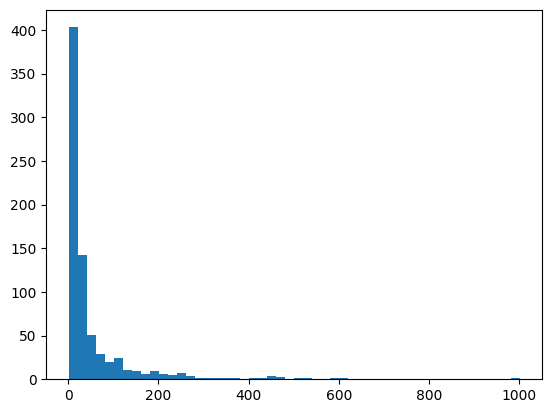

In [13]:
import matplotlib.pyplot as plt

train = split['train']['translation']
input_lens = [len(tr['en']) for tr in train]

plt.hist(input_lens, bins=50);

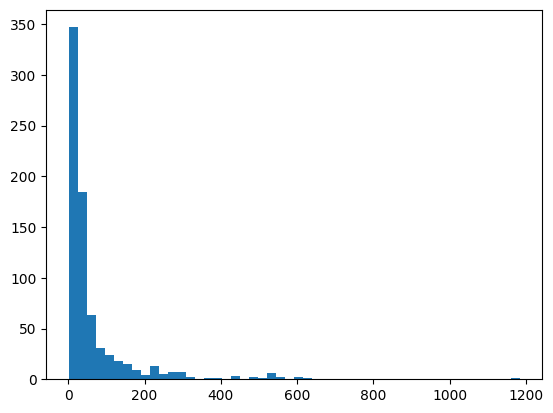

In [14]:
target_lens = [len(tr['pt']) for tr in train]
plt.hist(target_lens, bins=50);

In [15]:
max_input_len = 128
max_target_len = 128

def tokenizer_fn(batch):
  inputs = [x['en'] for x in batch['translation']]
  targets = [x['pt'] for x in batch['translation']]

  tokenized_inputs = tokenizer(
    inputs, max_length=max_input_len, truncation=True)

  tokenized_targets = tokenizer(
    text_target=targets, max_length=max_target_len, truncation=True)

  tokenized_inputs['labels'] = tokenized_targets['input_ids']
  return tokenized_inputs

In [16]:
tokenized_datasets = split.map(
    tokenizer_fn,
    batched=True,
    remove_columns=split['train'].column_names,
)

In [17]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [18]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [19]:
[tokenized_datasets["train"][i] for i in range(1, 3)]

[{'input_ids': [19106, 14823, 22257, 28, 44670],
  'attention_mask': [1, 1, 1, 1, 1],
  'labels': [19100, 4502, 4518, 37369, 28, 44670]},
 {'input_ids': [46001, 29170, 51611, 44026, 12, 23194, 46001, 44670],
  'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1],
  'labels': [12115, 12115, 16785, 28901, 143, 29170, 51611, 44026, 12, 44670]}]

In [20]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(1, 3)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [21]:
batch["labels"]

tensor([[19100,  4502,  4518, 37369,    28, 44670,  -100,  -100,  -100,  -100],
        [12115, 12115, 16785, 28901,   143, 29170, 51611, 44026,    12, 44670]])

In [22]:
# think of seq2seq RNNs - the decoder RNN must have "some" input
# it's just like a language model where we predict the next word from
# previous words!
batch["decoder_input_ids"]

tensor([[54775, 19100,  4502,  4518, 37369,    28, 44670, 54775, 54775, 54775],
        [54775, 12115, 12115, 16785, 28901,   143, 29170, 51611, 44026,    12]])

In [23]:
# the first token is a pad!
tokenizer.convert_ids_to_tokens(batch["decoder_input_ids"][0])

['<pad>',
 '▁Erro',
 '▁ao',
 '▁apagar',
 '▁pasta',
 '.',
 '</s>',
 '<pad>',
 '<pad>',
 '<pad>']

In [24]:
# the labels are one step ahead - just like a language model
tokenizer.convert_ids_to_tokens(batch["labels"][0])

['▁Erro',
 '▁ao',
 '▁apagar',
 '▁pasta',
 '.',
 '</s>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>']

In [25]:
split['train'][1]

{'id': '185194',
 'translation': {'en': 'Error deleting folder.',
  'pt': 'Erro ao apagar pasta.'}}

In [26]:
!pip install sacrebleu bert-score

In [27]:
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")
bert_metric = load_metric("bertscore")

<ipython-input-27-ec0ba0363219>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for sacrebleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/sacrebleu/sacrebleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for bertscore contains custom code which must be executed to correctly load the metric. You can insp

In [28]:
# targets must be in a list - as you recall, for bleu there can be multiple
# acceptable reference translations
bleu_metric.compute(predictions=["I love cats"], references=[["I love cats"]])

{'score': 0.0,
 'counts': [3, 2, 1, 0],
 'totals': [3, 2, 1, 0],
 'precisions': [100.0, 100.0, 100.0, 0.0],
 'bp': 1.0,
 'sys_len': 3,
 'ref_len': 3}

In [29]:
s = "Marian is an efficient NMT framework written in pure C++"
bleu_metric.compute(predictions=[s], references=[[s]])

{'score': 100.00000000000004,
 'counts': [12, 11, 10, 9],
 'totals': [12, 11, 10, 9],
 'precisions': [100.0, 100.0, 100.0, 100.0],
 'bp': 1.0,
 'sys_len': 12,
 'ref_len': 12}

In [30]:
bert_metric.compute(
    predictions=["I love cats"], references=[["I like cats"]], lang='en')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.9803369641304016],
 'recall': [0.9803369641304016],
 'f1': [0.9803369641304016],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.38.2)'}

In [31]:
import numpy as np

def compute_metrics(preds_and_labels):
  # preds are not logits, but token ids
  preds, labels = preds_and_labels

  # convert predictions into words
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

  # for any -100 label, replace with pad token id
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

  # convert labels into words
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # get rid of extraneous whitespace
  # and also, put targets into lists
  decoded_preds = [pred.strip() for pred in decoded_preds]
  decoded_labels = [[label.strip()] for label in decoded_labels]

  bleu = bleu_metric.compute(
      predictions=decoded_preds, references=decoded_labels)
  bert_score = bert_metric.compute(
      predictions=decoded_preds, references=decoded_labels, lang='pt')

  return {"bleu": bleu["score"], 'bert_score': np.mean(bert_score['f1'])}

In [32]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
  "finetuned-model",
  evaluation_strategy="no",
  save_strategy="epoch",
  learning_rate=2e-5,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=64,
  weight_decay=0.01,
  save_total_limit=3,
  num_train_epochs=3,
  predict_with_generate=True,
  fp16=True,
)

In [33]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [34]:
# let's check our metrics before we start!
trainer.evaluate(max_length=max_target_len)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

{'eval_loss': 1.7006464004516602,
 'eval_bleu': 31.81261253166696,
 'eval_bert_score': 0.8798354158401489,
 'eval_runtime': 49.6559,
 'eval_samples_per_second': 5.035,
 'eval_steps_per_second': 0.081}

In [35]:
# may run out of gpu memory - try to restart runtime
# or get a more powerful gpu!
trainer.train()

Step,Training Loss


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[54775]], 'forced_eos_token_id': 44670}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[54775]], 'forced_eos_token_id': 44670}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generatio

TrainOutput(global_step=72, training_loss=1.261993196275499, metrics={'train_runtime': 78.2861, 'train_samples_per_second': 28.741, 'train_steps_per_second': 0.92, 'total_flos': 203316069924864.0, 'train_loss': 1.261993196275499, 'epoch': 3.0})

In [36]:
# let's check our metrics again
trainer.evaluate(max_length=max_target_len)

{'eval_loss': 1.278113603591919,
 'eval_bleu': 42.94436467490814,
 'eval_bert_score': 0.9004894731044769,
 'eval_runtime': 21.7364,
 'eval_samples_per_second': 11.501,
 'eval_steps_per_second': 0.184,
 'epoch': 3.0}

In [37]:
trainer.save_model("my_saved_model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[54775]], 'forced_eos_token_id': 44670}


In [38]:
from transformers import pipeline
translator = pipeline("translation", model='my_saved_model', device=0)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [39]:
translator("I hope this course has helped you on your data science journey!")

[{'translation_text': 'Espero que este curso tenha ajudado você em sua jornada de ciência de dados!'}]